In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras
from keras.utils import np_utils
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Conv2D, MaxPooling2D,Dropout,MaxPooling1D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

In [2]:
dataset = pd.read_csv("D:/project/DRDO/Data_jash/Jash_Total_right.csv")
dataset

,0,1,2,3,4,5,6,7,8,9,...,2992,2993,2994,2995,2996,2997,2998,2999,label,Predicted
0,113,-32,47,-28,-62,28,53,-40,-37,28,...,71,-24,-66,36,64,-32,-61,41,Cylindrical,spherical
1,58,-97,28,27,-45,-25,38,21,-38,-21,...,69,-46,-68,54,66,-57,-59,61,Cylindrical,cylindrical
2,134,17,-45,-88,47,74,-54,-71,59,41,...,-96,6,95,-10,-94,22,91,-20,Cylindrical,lateral
3,51,-113,-47,37,27,-41,-26,54,25,-55,...,69,69,-68,-67,73,65,-76,-58,Cylindrical,cylindrical
4,41,-120,-63,25,53,-47,-51,50,47,-93,...,90,50,-94,-43,95,42,-97,-33,Cylindrical,cylindrical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,83,-71,-28,-4,10,-8,-14,14,15,-18,...,30,-12,-31,17,33,-13,-28,21,Hook,spherical
116,82,-68,-88,-59,26,7,-11,6,12,-17,...,-29,-19,20,16,-18,-18,25,12,Hook,spherical
117,83,-72,-2,2,-8,-3,10,9,-4,-13,...,27,19,-30,-13,32,14,-24,-14,Hook,spherical
118,104,-37,-24,-33,12,25,-18,-14,23,14,...,-7,23,4,-21,-9,23,5,-24,Hook,spherical


In [7]:
import tensorflow as tf

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="D:/project/DRDO/ML_gui_v2/jash_all.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = (1,3000,1)
output_shape = (1,6)
print(input_details)

interpreter.resize_tensor_input(input_details[0]['index'], input_shape)
interpreter.resize_tensor_input(output_details[0]['index'], output_shape)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# sperical data
# data = """ 19	-140	-13	63	-14	-94	15	112	-24	-101	9	113	-26	-113	19	114	-7	-109	21	108	-15	-112	13	122	-27	-85	20	88	-35	-68	43	50	-42	-30	53	20	-55	-1	61	-5	-61	-5	77	-21	-69	25	86	-30	-88	27	94	-31	-93	25	106	-16	-118	24	115	-24	-111	14	119	-19	-113	10	123	-21	-87	32	70	-27	-64	49	44	-46	-21	47	17	-63	-16	69	0	-64	12	71	-23	-75	13	87	-27	-95	33	91	-23	-94	30	97	-19	-99	22	102	-4	-121	18	117	-18	-114	13	109	-12	-101	18	87	-32	-56	40	45	-50	-32	57	28	-57	-22	63	-4	-67	0	76	-8	-83	13	91	-23	-90	21	95	-37	-97	35	107	-32	-110	34	108	-21	-109	27	118	-34	-91	33	99	-38	-75	46	60	-43	-45	53	32	-56	-31	63	24	-66	-18	65	6	-57	-17	77	-8	-74	10	84	-35	-98	34	101	-34	-104	42	101	-31	-98	31	102	-29	-104	16	114	-13	-113	20	115	-17	-122	22	113	-16	-114	27	120	-31	-91	34	83	-56	-66	61	44	-56	-23	57	9	-72	-3	97	-27	-86	38	89	-35	-98	28	95	-29	-90	31	90	-25	-100	22	107	-19	-105	23	129	-26	-121	12	127	-18	-115	21	99	-33	-74	37	69	-48	-45	51	43	-56	-32	69	7	-66	-5	86	-24	-88	38	92	-41	-92	39	102	-39	-97	38	94	-27	-111	29	106	-30	-110	20	117	-17	-122	23	128	-18	-124	24	106	-38	-91	48	70	-36	-76	53	39	-57	-25	63	10	-72	19	72	-13	-88	34	91	-29	-113	31	104	-26	-104	30	109	-37	-111	24	124	-25	-110	21	116	-14	-117	22	115	-29	-116	20	119	-26	-82	46	76	-61	-43	55	38	-67	-5	83	-6	-82	22	101	-50	-95	43	99	-36	-93	30	104	-36	-98	26	102	-20	-107	24	119	-32	-119	20	121	-12	-126	25	120	-24	-91	33	95	-51	-58	52	47	-59	-16	62	7	-70	-3	90	-16	-82	37	72	-30	-105	39	104	-42	-108	30	110	-38	-101	29	99	-19	-113	24	117	-36	-116	16	120	-26	-126	24	116	-17	-98	36	89	-39	-64	57	57	-60	-41	75	6	-68	-2	72	-1	-83	21	94	-40	-96	33	94	-31	-98	35	97	-40	-97	35	101	-18	-112	20	122	-37	-111	26	116	-19	-115	26	126	-17	-116	19	106	-33	-73	49	60	-54	-36	66	22	-60	-19	80	-2	-88	28	85	-44	-86	37	98	-37	-105	37	106	-33	-102	28	103	-24	-114	27	119	-21	-119	16	124	-20	-131	23	136	-32	-106	34	95	-42	-75	54	65	-57	-35	65	17	-77	-3	77	-29	-81	34	92	-44	-95	48	106	-40	-97	28	98	-28	-99	21	108	-27	-104	23	114	-16	-120	19	120	-24	-133	20	125	-17	-100	32	95	-44	-67	43	59	-52	-27	62	21	-66	-9	77	0	-78	12	76	-30	-82	43	92	-36	-101	33	104	-35	-102	31	107	-18	-124	30	103	-15	-117	26	124	-27	-129	25	125	-29	-117	37	105	-27	-84	55	72	-53	-37	52	25	-64	-5	72	-8	-81	23	101	-47	-101	31	106	-32	-102	29	100	-35	-109	25	126	-24	-111	23	110	-24	-120	18	118	-11	-141	34	113	-26	-91	34	78	-46	-65	62	50	-53	-37	70	10	-71	4	73	-15	-78	27	95	-41	-92	36	90	-38	-84	32	97	-29	-103	31	106	-20	-113	22	104	-20	-112	19	122	-26	-128	27	127	-18	-110	32	90	-27	-96	57	57	-49	-34	66	19	-69	-7	74	-7	-76	23	88	-49	-93	38	95	-36	-100	37	101	-30	-98	16	100	-16	-104	25	114	-23	-120	28	116	-16	-130	20	120	-17	-114	25	101	-30	-77	41	53	-48	-42	62	25	-67	-8	63	-11	-77	30	93	-34	-101	48	104	-37	-82	9	103	-24	-104	31	103	-25	-98	10	110	-21	-118	8	126	-19	-119	23	129	-14	-120	23	109	-32	-80	50	55	-52	-32	55	12	-62	-1	81	-3	-88	19	83	-40	-89	31	86	-40	-94	37	102	-30	-103	39	94	-22	-111	34	113	-30	-113	35	110	-21	-124	25	125	-18	-121	32	117	-29	-84	52	61	-46	-52	64	25	-63	-24	82	-5	-80	9	86	-33	-89	42	87	-39	-99	39	94	-37	-92	28	89	-23	-107	30	118	-22	-116	20	107	-22	-108	12	123	-24	-122	20	116	-25	-90	40	71	-41	-65	51	45	-61	-15	67	2	-80	12	85	-31	-88	40	99	-41	-104	48	97	-41	-108	29	100	-25	-108	30	109	-21	-109	25	114	-18	-129	24	127	-17	-120	23	107	-29	-77	42	77	-54	-44	61	30	-64	-10	80	-3	-82	15	84	-26	-98	39	96	-32	-97	36	100	-27	-104	29	111	-34	-107	26	111	-26	-118	29	121	-23	-126	26	131	-22	-120	25	101	-38	-71	41	65	-56	-43	71	19	-65	-7	77	-10	-78	23	83	-37	-87	42	100	-38	-105	37	105	-36	-99	27	106	-24	-108	23	98	-26	-115	24	116	-15	-123	26	132	-29	-118	28	96	-37	-70	47	56	-54	-52	65	21	-72	-5	81	-9	-75	22	85	-40	-99	36	95	-35	-99	31	74	0	-69	9	62	-23	-57	29	43	-7	-55	18	52	-20	-56	-2	52	-14	-51	15	63	-13	-70	21	60	-13	-46	30	41	-22	-28	18	22	-16	-8	22	1	-29	2	22	-5	-34	2	29	-10	-37	20	38	-23	-37	19	44	-14	-59	11	66	-18	-65	15	59	-9	-63	16	66	-12	-64	15	60	-20	-46	17	33	-21	-23	24	16	-18	-12	26	3	-28	0	25	-7	-34	6	35	-8	-38	16	47	-23	-38	17	45	-18	-47	13	49	-9	-52	4	66	-12	-62	10	59	-13	-63	8	60	-15	-48	21	44	-19	-18	22	15	-22	-11	22	16	-26	-2	24	-5	-32	4	36	-8	-43	12	41	-15	-43	22	42	-27	-53	21	47	-21	-53	13	51	-21	-58	24	60	-24	-50	26	48	-23	-30	24	26	-24	-12	25	14	-26	-13	28	6	-28	-5	24	11	-33	6	35	-8	-41	19	47	-21	-48	25	45	-31	-47	22	44	-22	-48	20	51	-12	-55	10	55	-14	-61	14	64	-17	-62	17	67	-22	-71	22	56	-21	-47	29	34	-29	-24	26	16	-25	-8	32	-1	-41	13	36	-22	-38	25	42	-22	-41	19	38	-20	-42	16	47	-16	-52	13	52	-19	-67	16	64	-13	-67	18	71	-16	-59	21	47	-22	-35	26	25	-24	-23	21	19	-29	-5	28	1	-38	10	38	-18	-43	27	41	-30	-46	29	42	-25	-43	19	53	-19	-51	20	56	-16	-61	15	63	-19	-68	16	67	-21	-69	27	60	-29	-38	20	34	-28	-30	25	14	-27	-2	28	-10	-32	7	38	-16	-39	22	49	-21	-44	16	48	-19	-56	24	59	-17	-64	19	56	-19	-60	14	59	-20	-60	24	63	-19	-70	19	56	-25	-39	34	29	-25	-17	28	10	-36	9	33	-10	-45	26	40	-32	-42	24	42	-23	-47	24	48	-16	-52	14	51	-17	-61	21	60	-15	-66	13	66	-21	-69	20	64	-22	-48	31	37	-29	-21	28	14	-26	0	30	-2	-38	6	35	-17	-31	18	44	-29	-47	27	49	-19	-50	25	51	-19	-50	16	58	-17	-61	24	60	-13	-63	22	65	-19	-67	15	63	-24	-48	22	40	-28	-25	27	28	-33	-10	31	0	-35	0	35	-12	-42	20	40	-27	-41	21	43	-24	-44	25	45	-22	-50	15	53	-16	-62	24	58	-20	-62	18	59	-23	-67	17	69	-17	-58	20	53	-25	-30	27	24	-30	-9	25	14	-33	2	37	-12	-35	25	37	-29	-45	27	47	-25	-50	19	49	-17	-53	16	57	-19	-62	16	60	-14	-68	15	69	-17	-74	25	70	-24	-57	30	46	-29	-32	27	22	-28	-9	35	4	-31	14	34	-17	-40	28	38	-34	-46	26	41	-21	-45	18	48	-15	-54	18	52	-18	-60	15	61	-16	-65	18	72	-16	-67	15	67	-23	-55	27	41	-24	-24	26	19	-29	-8	28	8	-33	-1	33	-5	-33	14	35	-25	-41	28	41	-23	-45	23	47	-18	-53	12	61	-19	-54	11	59	-20	-68	19	69	-20	-66	22	71	-28	-64	19	53	-32	-37	26	21	-25	-14	26	6	-27	5	33	-11	-43	21	43	-25	-47	24	45	-19	-45	21	53	-17	-65	16	57	-16	-59	17	62	-18	-64	13	74	-22	-68	19	61	-21	-44	26	37	-32	-25	22	26	-29	-7	34	0	-31	8	32	-12	-40	25	39	-26	-37	26	34	-20	-42	19	48	-19	-53	13	57	-14	-53	15	58	-16	-64	18	69	-20	-69	16	70	-22	-55	18	56	-33	-33	22	21	-30	-11	29	5	-31	6	33	-13	-36	20	42	-29	-41	23	42	-22	-45	20	44	-12	-48	12	52	-16	-61	15	64	-19	-65	13	68	-17	-66	16	70	-20	-62	19	51	-21	-26	24	26	-25	-14	26	7	-22	9	30	-11	-37	17	42	-32	-49	23	34	-10	-48	16	47	-18	-53	15	50	-9	-56	13	60	-8	-65	15	65	-16	-72	13	74	-19	-67	20	53	-26	-29	25	23	-25	-7	21	-3	-34	1	35	-9	-36	15	37	-23	-36	26	38	-26	-46	17	47	-24	-47	14	54	-23	-59	18	58	-26	-57	15	65	-19	-66	14	65	-20	-71	19	57	-29	-34	24	31	-29	-13	26	16	-34	2	31	-6	-36	13	36	-26	-38	26	43	-24	-43	23	42	-17	-41	15	50	-19	-60	13	60	-14	-57	17	58	-13	-65	19	67	-16	-67	19	61	-23	-40	22	38	-22	-21	27	16	-29	-4	34	-9	-37	13	35	-23	-41	31	43	-30	-43	25	50	-17	-48	16	52	-19	-56	14	53	-19	-61	13	68	-17	-68	13	70	-18	-65	18	51	-25	-43	28	27	-29	-17	27	10	-36	3	34	-7	-36	9	42	-22	-41	24	41	-24	-44	16	47	-18	-54	19	55	-17	-59	19	59	-22	-65	18	66	-20	-71	17	72	-18	-62	25	48	-22	-34	28	28	-32	-10	27	5	-32	7	32	-10	-36	16	37	-28	-43	28	45	-25	-47	21	47	-17	-51	15	53	-16	-50	17	59	-19	-60	13	64	-20	-70	21	74	-19	-58	24	42	-26	-30	27	29	-28	-13	31	4	-34	7	29	-10	-36	22	40	-27	-39	23	43	-20	-45	44	172	-100	-191	104	196	-92	-197	87	203	-81	-210	95	215	-79	-216	89	213	-98	-215	95	208	-98	-202	104	148	-113	-138	118	102	-128	-73	132	33	-151	-15	162	-10	-165	36	176	-31	-186	67	186	-83	-199	95	197	-90	-208	94	210	-92	-214	91	220	-93	-215	95	214	-95	-219	96	204	-92	-202	101	151	-114	-115	115	95	-136	-70	138	35	-149	-7	162	0	-171	24	176	-39	-181	65	184	-72	-200	91	200	-95	-205	89	204	-94	-208	87	209	-93	-214	86	218	-91	-215	97	216	-92	-202	96	175	-101	-151	111	90	-124	-75	136	52	-146	-42	153	20	-158	14	168	-18	-176	38	182	-50	-188	73	191	-79	-197	97	205	-93	-205	93	213	-95	-209	95	211	-97	-216	103	171	-106	-170	110	130	-122	-112	123	80	-135	-64	140	48	-149	-30	158	22	-161	-2	161	-10	-177	34	179	-46	-187	74	195	-88	-197	97	205	-99	-204	95	205	-93	-208	93	209	-89	-214	91	216	-95	-214	95	218	-99	-213	95	201	-102	-184	108	140	-114	-111	133	86	-141	-57	145	19	-155	15	168	-33	-190	69	189	-91	-195	93	203	-91	-203	93	204	-95	-203	94	208	-92	-211	95	211	-93	-220	100	215	-95	-220	96	193	-100	-164	112	121	-119	-105	131	72	-137	-52	149	22	-163	11	170	-27	-183	63	191	-90	-196	99	200	-96	-205	97	205	-98	-205	93	213	-95	-210	97	213	-94	-214	93	218	-98	-219	96	218	-101	-181	109	137	-119	-107	122	106	-133	-51	145	16	-155	8	172	-41	-176	60	190	-92	-197	92	211	-92	-209	94	210	-97	-212	101	210	-97	-216	98	210	-95	-211	93	214	-97	-212	100	204	-96	-184	104	125	-124	-104	136	52	-142	-33	158	-18	-173	37	181	-66	-196	101	198	-95	-204	96	202	-92	-211	96	208	-93	-207	93	212	-95	-215	99	217	-95	-213	94	219	-100	-207	101	150	-112	-138	126	88	-131	-69	142	21	-153	0	163	-13	-180	42	181	-77	-180	91	204	-94	-206	96	208	-94	-212	98	208	-97	-208	92	214	-95	-215	100	214	-94	-214	98	218	-98	-199	98	155	-112	-132	120	89	-136	-80	143	45	-159	1	165	-16	-169	37	183	-63	-192	98	200	-92	-202	93	204	-93	-205	98	205	-98	-205	90	214	-93	-217	102	212	-98	-212	96	213	-98	-217	96	190	-97	-171	110	108	-127	-88	135	46	-148	-25	155	-8	-172	36	184	-73	-190	99	196	-95	-203	95	209	-94	-211	96	209	-94	-208	95	214	-97	-213	95	217	-92	-216	96	221	-98	-222	103	173	-110	-142	117	102	-130	-81	139	37	-152	-8	165	-21	-174	58	183	-81	-191	97	199	-97	-205	97	205	-91	-207	95	207	-93	-211	97	209	-97	-212	94	217	-94	-216	97	221	-96	-217	96	169	-106	-142	119	96	-125	-87	138	42	-148	-27	158	0	-169	19	176	-42	-179	74	188	-98	-195	93	205	-93	-208	94	209	-94	-210	91	219	-98	-206	93	217	-97	-217	99	219	-97	-218	101	197	-105	-163	107	115	-127	-92	137	53	-141	-26	155	-10	-167	33	179	-62	-194	101	200	-94	-207	92	206	-92	-208	98	212	-94	-217	95	212	-95	-210	98	216	-93	-214	90	226	-104	-195	102	147	-112	-118	125	90	-137	-68	141	33	-161	-1	166	-26	-172	49	182	-80	-196	95	198	-94	-200	95	198	-93	-207	93	210	-95	-211	91	213	-94	-208	95	213	-93	-218	97	220	-99	-218	95	184	-105	-149	111	126	-130	-83	136	43	-150	-15	162	-14	-171	35	177	-58	-191	99	197	-93	-200	94	206	-96	-206	95	206	-89	-209	91	212	-93	-215	96	219	-98	-211	93	222	-97	-215	95	193	-101	-160	110	111	-124	-83	132	49	-149	-18	160	-17	-167	38	180	-72	-193	94	204	-97	-204	96	197	-83	-208	92	212	-96	-209	95	206	-86	-212	95	215	-89	-221	96	217	-98	-217	95	190	-102	-158	114	106	-130	-78	139	37	-143	-2	162	-16	-175	35	187	-59	-189	96	196	-92	-197	98	203	-93	-206	95	209	-98	-202	93	213	-96	-212	99	212	-98	-210	93	218	-95	-216	93	206	-102	-179	107	124	-125	-94	129	62	-146	-26	154	-1	-172	34	180	-48	-187	84	195	-96	-196	94	206	-95	-204	95	203	-93	-202	91	212	-94	-216	94	215	-95	-212	97	211	-90	-219	97	212	-97	-193	102	141	-116	-112	122	82	-137	-59	150	11	-159	20	175	-40	-181	74	190	-96	-200	96	206	-98	-204	96	209	-93	-205	94	212	-96	-209	94	213	-93	-213	93	222	-96	-219	96	201	-99	-174	109	125	-120	-105	133	62	-142	-34	154	-4	-169	24	177	-46	-184	78	197	-96	-200	93	203	-93	-206	92	210	-92	-214	98	211	-95	-209	97	216	-99	-214	96	219	-97	-220	96	195	-103	-161	113	112	-122	-93	135	52	-151	-21	157	-6	-169	28	177	-55	-185	89	193	-95	-202	94	206	-94	-210	97	207	-92	-210	94	211	-94	-206	96	214	-94	-214	93	219	-97	-222	100	186	-106	-148	116	108	-125	-85	135	58	-148	-17	162	-16	-173	40	179	-68	-187	96	201	-93	-202	94	204	-93"""
data = """182	-14	-62	-83	99	70	-74	-29	94	46	-69	-9	92	-18	-79	-26	88	20	-77	14	93	11	-70	-12	71	-9	-95	11	93	-29	-81	27	74	-27	-54	42	80	-43	-76	49	51	-44	-54	59	53	-72	-59	48	42	-49	-32	80	40	-69	-40	93	21	-86	-29	63	2	-81	-42	88	-9	-96	0	96	-8	-81	4	109	-9	-105	12	118	-12	-82	21	80	-24	-64	51	79	-55	-70	56	55	-58	-88	50	55	-68	-45	66	49	-73	-31	75	44	-76	-11	76	21	-69	7	68	12	-81	-41	86	3	-88	2	74	17	-71	4	72	-27	-87	5	82	-49	-55	13	59	-19	-79	-14	70	-26	-46	19	44	-15	-40	38	37	-42	-57	51	54	-42	-31	69	47	-55	-44	67	32	-63	-32	61	11	-60	-21	70	22	-54	-30	60	5	-72	-2	59	3	-63	0	73	-4	-59	10	83	-7	-75	11	70	-19	-65	13	41	-27	-45	29	64	-29	-56	35	50	-30	-34	43	51	-47	-46	51	46	-62	-35	61	29	-72	-32	42	29	-100	-17	67	20	-45	16	56	-2	-63	-2	90	-14	-56	9	73	4	-67	12	77	-23	-63	21	71	-34	-47	25	58	-46	-71	26	51	-40	-56	66	69	-36	-39	47	18	-58	-33	60	27	-64	-27	72	28	-53	-11	64	12	-65	-20	57	16	-56	-18	49	-3	-63	-5	68	-4	-61	22	80	-5	-49	7	80	-16	-73	11	50	-22	-47	35	55	-26	-56	38	60	-42	-48	45	54	-40	-49	50	42	-59	-47	54	47	-47	-41	66	24	-57	-27	70	26	-55	0	84	29	-60	-5	72	12	-58	-2	63	2	-64	-5	73	-22	-61	17	69	-7	-61	11	54	-30	-65	12	50	-32	-50	34	52	-32	-52	39	55	-51	-44	52	48	-54	-42	61	56	-55	-27	57	34	-70	-25	56	29	-67	-20	60	18	-42	0	68	17	-63	-6	73	3	-70	12	54	-2	-52	18	63	-19	-45	18	57	-41	-52	10	59	-26	-61	33	49	-34	-46	37	64	-45	-43	32	48	-50	-37	49	40	-62	-53	53	29	-53	-27	56	16	-62	-20	70	21	-66	-9	51	2	-71	-12	63	-3	-62	0	65	-11	-61	27	73	-17	-67	12	63	-19	-55	19	49	-24	-60	23	56	-34	-50	35	48	-31	-29	33	47	-46	-43	48	38	-57	-35	49	32	-54	-23	58	23	-63	-10	71	12	-58	-12	61	4	-59	-1	72	4	-64	1	56	0	-68	1	71	-3	-81	0	64	-10	-61	15	59	-17	-53	22	58	-25	-55	24	46	-30	-56	32	56	-31	-44	36	44	-34	-43	51	43	-52	-37	51	18	-61	-27	61	24	-57	-19	59	15	-61	-12	70	15	-70	-12	63	5	-66	5	62	5	-61	-2	61	-9	-56	12	71	-12	-53	7	59	-28	-54	27	49	-15	-43	26	51	-38	-46	34	45	-41	-39	38	48	-34	-45	55	37	-47	-33	47	32	-59	-26	60	15	-56	-15	60	12	-69	-10	61	-2	-63	0	65	1	-59	-6	69	-5	-63	11	67	-19	-62	12	56	-14	-54	16	53	-32	-59	23	61	-21	-50	34	50	-37	-35	35	48	-38	-43	44	45	-50	-47	51	39	-55	-31	57	23	-55	-24	64	20	-67	-8	66	13	-73	-12	63	15	-68	3	60	0	-70	-1	61	-4	-64	5	79	-11	-69	4	62	-14	-59	11	50	-23	-57	25	55	-29	-45	36	50	-41	-52	37	46	-42	-41	40	41	-52	-43	36	30	-49	-29	52	28	-59	-31	60	24	-56	-27	66	4	-70	-11	56	10	-66	-9	65	-4	-57	13	60	-5	-57	4	65	-5	-53	17	60	-23	-57	19	56	-29	-54	27	53	-26	-52	24	44	-44	-53	50	39	-39	-42	48	39	-31	-33	50	23	-68	-28	44	15	-54	-18	76	15	-58	-17	60	3	-56	3	59	7	-54	1	60	-9	-57	0	66	-3	-65	12	63	-8	-57	13	57	-15	-48	20	59	-33	-52	28	52	-34	-55	34	54	-42	-37	27	46	-47	-39	32	36	-52	-35	57	29	-58	-19	46	25	-68	-13	62	11	-57	-14	77	4	-71	0	59	0	-58	0	67	1	-50	6	65	-15	-64	14	53	-17	-45	16	59	-23	-53	24	50	-32	-45	23	51	-45	-50	38	51	-41	-46	47	34	-46	-39	52	27	-51	-34	54	25	-55	-19	63	18	-59	-10	61	15	-60	-8	57	11	-82	3	69	8	-61	5	62	0	-55	7	59	5	-54	13	60	-21	-43	19	62	-15	-56	30	44	-32	-45	34	43	-53	-53	34	42	-38	-44	43	42	-51	-33	50	20	-44	-21	59	15	-59	-27	54	16	-61	-9	58	12	-62	-10	66	6	-58	-5	53	0	-56	-6	66	-6	-58	6	52	-10	-50	8	57	-16	-55	12	48	-17	-50	25	46	-24	-49	26	49	-24	-49	45	47	-36	-50	43	40	-48	-36	49	30	-47	-29	60	26	-57	-21	57	21	-58	-27	59	9	-57	-7	52	9	-54	-4	55	2	-58	0	63	-5	-61	12	66	-12	-65	11	54	-13	-53	21	51	-20	-40	31	48	-36	-51	31	45	-37	-51	36	48	-37	-37	48	29	-54	-37	50	33	-44	59	66	6	-83	-13	44	-2	-41	-2	25	0	-38	3	35	20	-40	-14	46	-7	-45	-10	40	0	-42	2	40	-3	-49	14	49	-15	-37	9	32	-29	-40	19	35	-33	-28	19	28	-33	-21	34	35	-23	-17	23	15	-41	-17	35	25	-47	-9	43	5	-36	2	39	17	-41	1	48	0	-41	5	48	-6	-57	4	62	-10	-58	2	48	-18	-38	10	31	-31	-40	26	38	-31	-23	30	45	-22	-28	38	25	-34	-22	40	14	-44	-21	36	0	-41	-9	37	-2	-35	0	45	18	-31	-6	63	-8	-40	-10	35	-3	-38	8	54	-4	-42	24	36	-15	-31	11	40	2	-37	13	20	-8	-17	7	20	-21	-18	23	28	-25	-33	19	15	-42	-20	29	21	-33	-20	39	8	-29	-7	33	8	-34	-13	27	12	-30	-5	40	0	-32	0	33	0	-45	0	37	-9	-43	2	47	-8	-39	5	37	-11	-18	17	26	-17	-29	15	35	-20	-27	13	16	-27	-30	19	25	-35	-21	31	18	-36	-14	44	16	-25	-9	54	15	-37	-10	24	-15	-30	1	36	-2	-43	6	33	-7	-39	-2	36	-7	-40	11	34	-16	-40	20	28	-15	-30	26	36	-20	-22	21	29	-36	-36	21	22	-31	-11	31	11	-36	-13	40	11	-35	-14	26	-1	-36	-4	35	10	-28	-8	32	3	-24	2	34	1	-34	4	36	-15	-44	1	28	-7	-37	8	42	-6	-26	13	24	-24	-31	13	28	-25	-32	16	27	-30	-32	17	26	-29	-21	30	26	-32	-26	23	17	-37	-13	31	16	-37	-16	28	-3	-44	-13	34	0	-40	-8	27	0	-36	-3	32	0	-38	11	36	-14	-34	5	31	-10	-29	17	33	-6	-23	18	25	-16	-31	15	26	-25	-29	24	24	-31	-27	27	20	-35	-31	30	11	-33	-20	38	10	-34	-13	36	12	-30	-8	18	-4	-38	-9	29	0	-37	-3	41	-11	-32	2	30	-14	-29	10	26	-16	-29	20	26	-7	-32	11	31	-16	-27	14	26	-24	-32	21	25	-23	-24	27	18	-28	-20	33	30	-31	-13	27	11	-30	-7	33	8	-37	-10	34	2	-30	0	40	1	-35	2	36	-5	-35	5	35	-12	-38	7	39	-8	-32	12	29	-14	-23	14	32	-16	-30	13	27	-19	-23	14	13	-21	-22	22	22	-31	-21	27	19	-25	-13	26	11	-31	-9	37	1	-38	-8	35	2	-31	1	31	0	-37	-1	40	-3	-28	1	37	-3	-37	0	44	1	-30	4	37	-9	-34	8	29	-16	-29	13	28	-18	-25	14	29	-20	-28	13	23	-22	-22	19	24	-28	-20	25	19	-31	-8	35	11	-35	-14	27	5	-33	-11	31	3	-37	-10	37	6	-37	-2	35	-3	-34	-1	35	-2	-33	6	30	-8	-37	2	31	-8	-30	13	31	-17	-26	6	21	-16	-29	17	24	-22	-22	20	19	-26	-29	15	22	-35	-23	19	17	-25	-13	33	13	-32	-5	32	3	-32	-4	37	4	-33	1	36	-5	-33	0	33	0	-35	2	34	-8	-39	8	34	-7	-28	9	26	-10	-26	14	31	-15	-34	8	27	-19	-31	18	17	-24	-23	19	21	-22	-25	28	26	-26	-20	30	18	-32	-11	36	11	-32	-8	38	0	-35	-7	40	6	-34	-7	34	-7	-33	-1	39	-2	-32	1	37	-2	-42	6	38	-5	-34	6	36	-7	-24	12	31	-17	-31	14	26	-21	-25	19	30	-25	-23	22	20	-25	-19	24	24	-22	-13	28	16	-26	-8	30	17	-33	-14	28	12	-33	-3	39	3	-34	-6	33	3	-34	4	33	-9	-30	1	32	-7	-31	0	25	-12	-31	11	32	-15	-28	14	28	-19	-30	13	27	-16	-20	23	29	-29	-20	22	22	-28	-19	17	15	-29	-8	35	12	-25	-4	29	6	-38	-9	33	6	-32	-4	31	-5	-30	-4	30	-3	-31	3	34	-4	-34	0	35	-7	-32	2	32	-9	-33	7	27	-15	-35	15	29	-19	-28	18	28	-22	-26	19	22	-18	-22	24	17	-18	-16	28	16	-31	-15	28	10	-29	-10	35	3	-33	-5	28	6	-41	-5	36	-2	-35	1	31	-3	-33	-1	27	-6	-36	5	34	-12	-27	7	26	-14	-28	12	31	-16	-25	14	24	-15	-25	23	27	-22	-28	19	26	-26	-18	24	19	-32	-12	28	15	-29	-12	27	8	-34	-9	30	3	-34	-9	33	2	-29	-7	44	-1	-38	-5	34	-3	-32	2	33	-6	-30	-4	31	-10	-32	10	25	-13	-34	7	31	-16	-26	16	25	-22	-23	28	27	-22	-24	20	23	-23	-19	24	17	-27	-10	27	6	-34	-6	32	14	-26	-6	33	5	-33	-7	33	3	-35	-4	35	0	-28	-2	31	0	-32	2	32	-4	-26	6	26	-9	-27	9	29	-8	-28	8	27	-14	-23	14	24	-17	-26	10	25	-23	-27	19	25	-26	-23	25	16	-29	-17	29	14	-35	-14	30	8	-32	-11	31	13	-31	-8	29	2	-28	-5	31	0	-29	1	33	-1	-30	3	34	-12	-40	3	37	-7	-28	8	28	-13	-28	7	19	-23	-26	16	23	-19	-23	19	27	-24	-26	17	19	-28	-16	29	20	-33	-18	21	26	-249	-9	140	9	-157	-12	151	-8	-159	-7	153	-15	-167	41	160	-35	-170	49	150	-68	-161	70	140	-68	-123	90	146	-98	-143	110	122	-106	-116	121	92	-123	-99	140	96	-135	-69	144	54	-146	-60	160	48	-154	-38	159	22	-174	-24	172	2	-185	18	184	-15	-163	38	171	-22	-169	60	165	-60	-176	70	156	-69	-171	83	156	-86	-167	104	129	-102	-121	118	105	-129	-104	142	82	-142	-77	147	85	-149	-61	157	42	-161	-38	168	16	-159	-12	164	-2	-159	2	152	-31	-153	22	153	-11	-183	45	151	-38	-130	36	125	-46	-124	69	117	-59	-118	91	95	-67	-100	79	111	-63	-98	87	82	-91	-83	92	74	-99	-70	101	78	-112	-59	120	36	-128	-44	126	37	-140	-15	129	20	-129	-1	125	1	-130	7	124	-6	-129	27	132	-28	-123	28	129	-36	-125	48	113	-47	-132	57	116	-56	-111	74	100	-69	-92	78	86	-81	-102	87	84	-88	-75	96	65	-97	-65	115	54	-112	-52	128	38	-126	-29	127	19	-113	-22	141	-2	-121	9	114	-25	-119	26	119	-26	-137	40	116	-40	-122	41	116	-53	-119	68	109	-67	-109	78	90	-78	-91	94	92	-82	-83	97	78	-114	-81	104	59	-104	-38	118	42	-119	-29	117	21	-126	-11	124	4	-126	-1	126	-3	-122	14	120	-13	-117	31	122	-32	-125	41	117	-49	-124	50	101	-52	-122	61	109	-62	-96	74	93	-77	-88	82	87	-79	-87	97	77	-94	-70	105	64	-106	-58	119	50	-113	-39	118	36	-126	-23	122	13	-126	0	123	-14	-137	5	122	-15	-123	18	122	-26	-116	36	119	-35	-123	57	108	-55	-112	57	107	-61	-98	72	97	-69	-89	80	86	-87	-78	94	75	-92	-74	106	63	-104	-57	114	51	-118	-47	121	31	-121	-23	131	14	-119	-11	124	-2	-120	9	118	-17	-122	17	122	-23	-130	37	123	-44	-112	45	104	-53	-112	62	96	-58	-98	79	92	-65	-90	80	90	-84	-79	96	70	-92	-78	108	58	-98	-56	113	45	-111	-42	122	37	-118	-22	122	15	-121	-4	124	1	-125	4	127	-12	-117	21	127	-18	-119	34	116	-30	-118	40	108	-54	-115	57	106	-59	-105	68	97	-70	-96	78	93	-73	-86	91	75	-91	-71	99	57	-96	-63	112	53	-105	-44	116	32	-112	-28	121	16	-123	-10	122	1	-127	6	117	-9	-119	13	118	-21	-129	26	117	-32	-117	35	119	-37	-120	41	118	-45	-115	57	106	-60	-101	69	94	-69	-94	79	90	-75	-79	88	78	-87	-77	98	64	-98	-61	100	50	-110	-47	118	36	-115	-20	121	21	-118	-9	123	8	-118	3	122	-7	-124	12	127	-19	-118	28	120	-38	-119	37	115	-40	-110	50	104	-52	-111	66	95	-61	-99	77	89	-74	-83	77	80	-79	-76	96	67	-90	-65	102	60	-94	-53	107	52	-108	-39	115	31	-117	-27	120	15	-122	-6	119	2	-120	4	124	-10	-120	25	118	-24	-120	32	114	-29	-120	42	117	-45	-112	56	104	-57	-98	63	96	-65	-95	79	95	-71	-89	77	84	-84	-75	95	63	-88	-68	96	61	-104	-55	107	48	-111	-42	117	29	-120	-20	114	13	-125	-5	124	-1	-124	6	124	-13	-116	20	122	-25	-116	34	117	-31	-114	39	111	-45	-117	53	107	-52	-104	63	94	-62	-92	75	91	-73	-87	83	76	-85	-81	97	72	-91	-65	98	58	-95	-56	114	48	-106	-40	111	26	-115	-28	122	19	-120	-7	120	4	-124	13	126	-11	-110	20	118	-25	-117	35	107	-42	-109	47	102	-44	-106	55	103	-61	-104	73	93	-69	-90	82	87	-77	-81	86	73	-83	-71	99	68	-102	-55	103	51	-108	-46	104	34	-111	-25	125	18	-112	-8	116	3	-128	6	118	-8	-118	24	114	-25	-116	26	111	-31	-116	43	109	-38	-113	47	107	-53	-108	59	103	-59	-99	67	93	-67	-92	82	84	-79	-79	90	76	-87	-75	100	55	-90	-56	107	49	-102	-42	114	35	-115	-26	122	11	-111	-7	122	-1	-117	8	118	-10	-124	24	125	-27	-113	31	110	-31	-117	38	109	-40	-113	55	108	-51	-102	66	92	-63	-100	74	86	-72	-83	86	76	-81	-76	96	69	-91	-67	102	57	-105	-44	111	39	-110	-30	113	28	-112	-18	119	8	-119	-4	122	-2	-118	6	116	-13	-116	16	125	-27	-117	27	111	-38	-115	38	105	-40	-109	45	102	-53	-102	63	86	-64	-94	69	89	-76	-76	84	71	-83	-66	98	68	-88	-56	96	50	-99	-47	110	36	-110	-22	107	18	-112	-12	110	9	-113	-4	117	-5	-111	10	114	-12	-117	21	107	-21	-105	32	104	-30	-111	42	103	-44	-100	53	94	-49	-99	55	95	-56	-87	67	84	-71	-80	73	78	-71	-73	78	70	-90	-62	92	61	-93	-47	102	45	-104	-34	105	26	-109	-18	112	11	-110	-6	112	6	-112	10	112	-12	-109	17	108	-26	-111	28	107	-32	-113	43	110	-41	-105	52	100	-53	-94	59	90	-63	-85	71	81	-69	-75	81	76	-80	-70	92	67	-87	-62	98	53	-101	-44	108	40	-98	-34	104"""
# Split the data into individual values and convert them into a list
data_values = [int(val) for val in data.split()]

data_list = data.split()
input_data = np.array([data_values], dtype=np.float32)
input_data = input_data.reshape(input_data.shape[0], input_data.shape[1], 1)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
tflite_model_predictions
predicted_label_index = np.argmax(tflite_model_predictions)
predicted_label_index
actions = ["cylindrical", "hook", "lateral", "palmer", "spherical", "tip"]

predicted_label = actions[predicted_label_index]
predicted_label

tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
tflite_model_predictions

predicted_label_index = np.argmax(tflite_model_predictions)
predicted_label_index

actions = ["cylindrical", "hook", "lateral", "palmer", "spherical", "tip"]

predicted_label = actions[predicted_label_index]
predicted_label


[{'name': 'serving_default_conv1d_input:0', 'index': 0, 'shape': array([   1, 3000,    1]), 'shape_signature': array([  -1, 3000,    1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


'tip'

### new model creation for one sensor classification and 2 labels classifcation

In [13]:
selected_labels = ['Cylindrical', 'Tip']
df = dataset[dataset['label'].isin(selected_labels)]
df.drop('Predicted',axis=1,inplace=True)
df = df.reset_index()
df

C:\Users\Karthik\AppData\Local\Temp\ipykernel_34244\986132822.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('Predicted',axis=1,inplace=True)


,index,0,1,2,3,4,5,6,7,8,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,label
0,0,113,-32,47,-28,-62,28,53,-40,-37,...,28,71,-24,-66,36,64,-32,-61,41,Cylindrical
1,1,58,-97,28,27,-45,-25,38,21,-38,...,54,69,-46,-68,54,66,-57,-59,61,Cylindrical
2,2,134,17,-45,-88,47,74,-54,-71,59,...,-5,-96,6,95,-10,-94,22,91,-20,Cylindrical
3,3,51,-113,-47,37,27,-41,-26,54,25,...,-71,69,69,-68,-67,73,65,-76,-58,Cylindrical
4,4,41,-120,-63,25,53,-47,-51,50,47,...,-53,90,50,-94,-43,95,42,-97,-33,Cylindrical
5,5,133,43,-23,-103,29,92,-33,-78,39,...,82,-32,-79,42,77,-44,-72,47,74,Cylindrical
6,6,78,-92,41,27,-52,-18,41,25,-39,...,-57,70,55,-70,-46,76,44,-73,-41,Cylindrical
7,7,113,-46,73,-17,-78,0,62,-11,-58,...,-41,82,38,-82,-33,82,34,-82,-31,Cylindrical
8,8,109,-38,64,-26,-83,22,63,-16,-58,...,79,-59,-84,68,77,-64,-75,81,74,Cylindrical
9,9,43,-102,-65,17,53,-28,-47,41,41,...,70,82,-69,-75,70,75,-75,-67,81,Cylindrical


In [16]:
df.iloc[0, :3000]

index      0
0        113
1        -32
2         47
3        -28
        ... 
2994     -66
2995      36
2996      64
2997     -32
2998     -61
Name: 0, Length: 3000, dtype: object

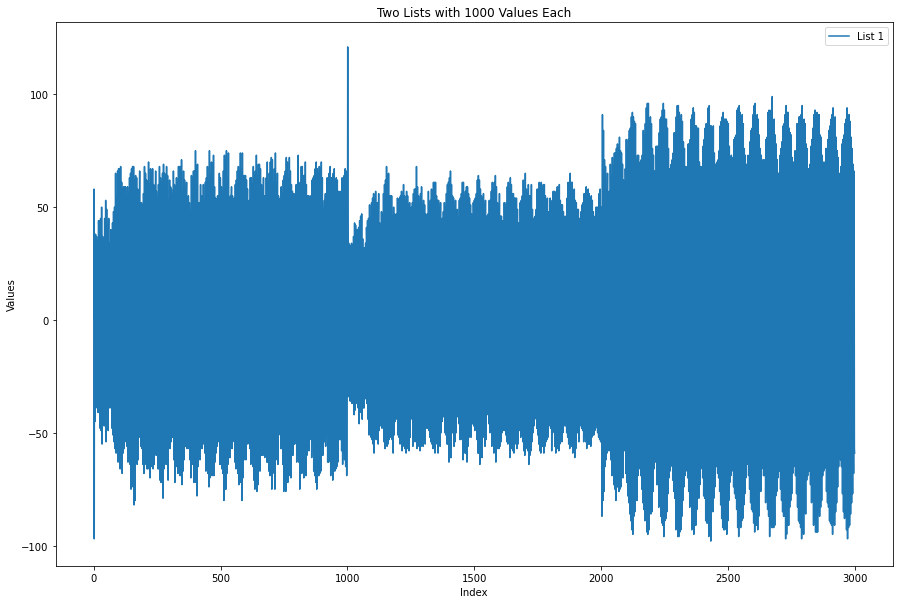

In [25]:
#cylinder data 
list1 = df.iloc[1,:3000]
x = list(range(3000))

# Create a figure and axis
plt.figure(figsize=(15, 10))

# Plot the two lists on the same axis
plt.plot(x, list1, label='List 1')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Two Lists with 1000 Values Each')
plt.legend()

# Display the plot
plt.show()

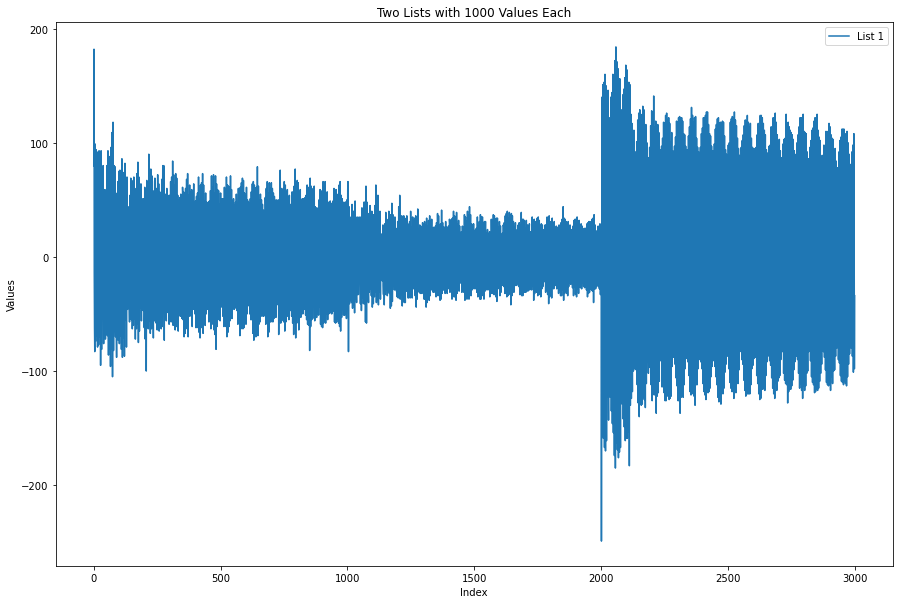

In [24]:
#cylinder data 
list1 = df.iloc[20,:3000]
x = list(range(3000))

# Create a figure and axis
plt.figure(figsize=(15, 10))

# Plot the two lists on the same axis
plt.plot(x, list1, label='List 1')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Two Lists with 1000 Values Each')
plt.legend()

# Display the plot
plt.show()

### surya dataset

In [28]:
dfs = pd.read_csv("D:/project/DRDO/ML_gui_v2/surya_emg_data.csv")
dfs 

,1,2,3,4,5,6,7,8,9,10,...,1492,1493,1494,1495,1496,1497,1498,1499,1500,label
0,44,2,28,24,30,36,30,31,35,32,...,-10,-10,-10,-10,-10,-9,-10,-10,-10,close
1,45,2,27,23,31,36,30,31,35,32,...,-11,-11,-10,-10,-10,-9,-9,-9,-9,close
2,45,2,27,24,31,37,30,31,35,32,...,-11,-11,-10,-10,-9,-9,-10,-10,-10,close
3,44,2,28,24,31,36,31,31,35,32,...,-10,-10,-10,-10,-10,-10,-10,-9,-10,close
4,45,3,27,23,31,36,30,31,35,32,...,-10,-10,-10,-9,-10,-11,-11,-11,-10,close
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,-56,16,30,30,-11,-25,18,36,-12,...,-16,51,84,22,-14,65,85,0,-19,open
96,50,7,29,-20,-26,24,36,-15,-28,22,...,88,0,-21,63,87,-1,-20,-18,72,open
97,0,-56,14,28,-14,-26,21,36,-13,-29,...,63,87,0,-20,-16,72,42,-9,-16,open
98,47,-40,-32,11,35,-8,-32,21,40,-15,...,-18,-18,69,87,0,-16,63,86,2,open


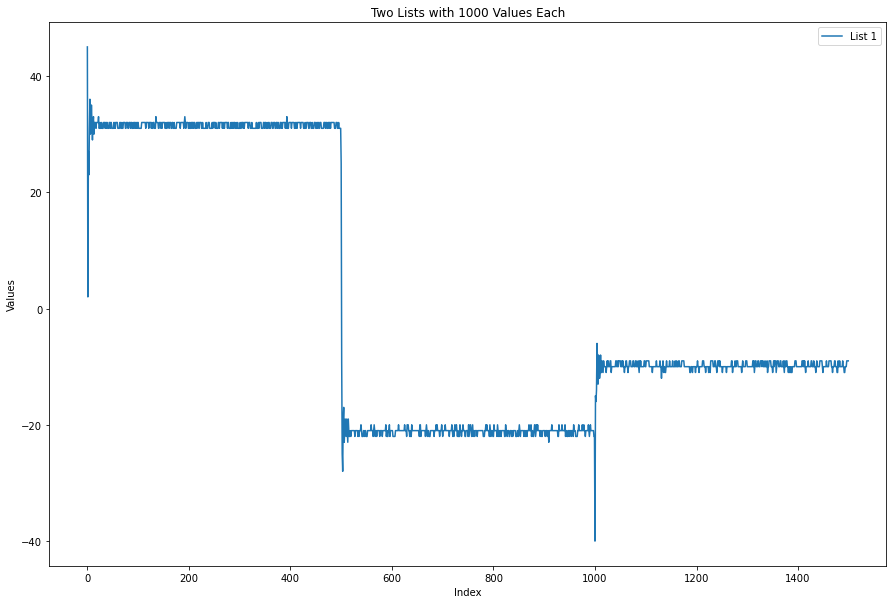

In [33]:
# close action plot 
list1 = dfs.iloc[1,:1500]
x = list(range(1500))

# Create a figure and axis
plt.figure(figsize=(15, 10))

# Plot the two lists on the same axis
plt.plot(x, list1, label='List 1')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Two Lists with 1000 Values Each')
plt.legend()

# Display the plot
plt.show()

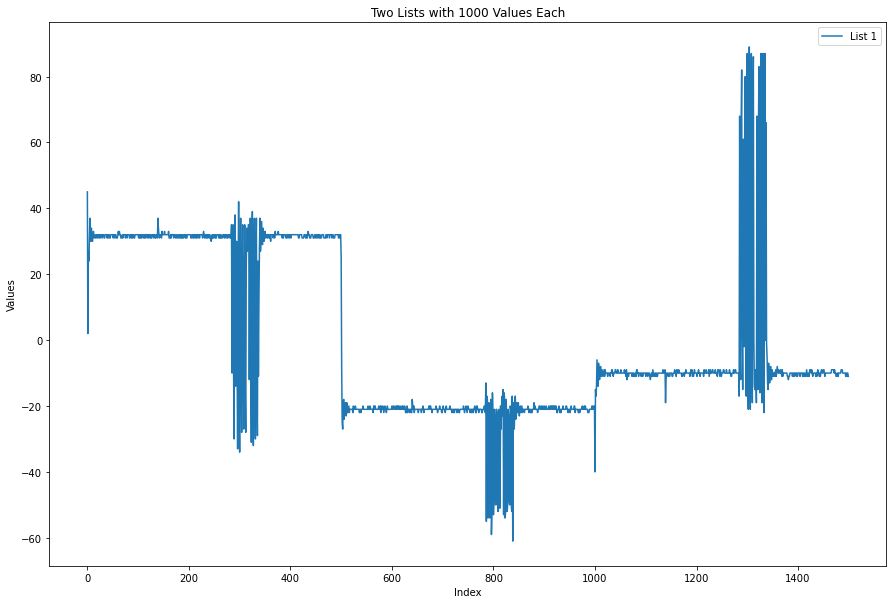

In [35]:
# open action plot 
list1 = dfs.iloc[52,:1500]
x = list(range(1500))

# Create a figure and axis
plt.figure(figsize=(15, 10))

# Plot the two lists on the same axis
plt.plot(x, list1, label='List 1')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Two Lists with 1000 Values Each')
plt.legend()

# Display the plot
plt.show()

In [47]:
X = dfs.iloc[:, :-1]
print(X)
print(X.shape)
y = dfs.iloc[:, -1]
print(y)

     1   2   3   4   5   6   7   8   9  10  ...  1491  1492  1493  1494  1495  \
0   44   2  28  24  30  36  30  31  35  32  ...   -10   -10   -10   -10   -10   
1   45   2  27  23  31  36  30  31  35  32  ...   -10   -11   -11   -10   -10   
2   45   2  27  24  31  37  30  31  35  32  ...   -11   -11   -11   -10   -10   
3   44   2  28  24  31  36  31  31  35  32  ...   -10   -10   -10   -10   -10   
4   45   3  27  23  31  36  30  31  35  32  ...   -10   -10   -10   -10    -9   
..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   ...   ...   ...   ...   ...   
95   0 -56  16  30  30 -11 -25  18  36 -12  ...    16   -16    51    84    22   
96  50   7  29 -20 -26  24  36 -15 -28  22  ...    62    88     0   -21    63   
97   0 -56  14  28 -14 -26  21  36 -13 -29  ...   -21    63    87     0   -20   
98  47 -40 -32  11  35  -8 -32  21  40 -15  ...    -3   -18   -18    69    87   
99  48   5 -17 -36  17  40 -15 -33  22  37  ...    86     0   -21    64    86   

    1496  1497  1498  1499 

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'X' contains your features and 'y' contains your target labels

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing the Random Forest Classifier
clf = RandomForestClassifier()

# Training the model
clf.fit(X_train, y_train)

# Predicting on the test set
y_pred = clf.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8
Classification Report:
              precision    recall  f1-score   support

       close       0.90      0.75      0.82        12
        open       0.70      0.88      0.78         8

    accuracy                           0.80        20
   macro avg       0.80      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



In [44]:
import joblib

# Assuming 'clf' is your trained Random Forest Classifier
# Save the model as an HDF5 file
joblib.dump(clf, 'random_forest_model.h5', compress=True)


['random_forest_model.h5']

In [45]:
# prediction code 
# Load the model from the HDF5 file
loaded_model = joblib.load('random_forest_model.h5')

# Use the loaded model to make predictions
# For example:
new_data = ...  # Your new data for prediction
predictions = loaded_model.predict(new_data)


### deep learning model surya data 


In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D, Flatten, Dense, LSTM
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping




# Reshape the input data for Conv1D layer (assuming x has 1500 values in each row)
X_array = X.to_numpy().reshape((X.shape[0], X.shape[1], 1))
y_array = y.to_numpy()
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_array)

# Check the classes and their corresponding encoded values
print("Classes:", label_encoder.classes_)
print("Encoded values:", np.unique(y_encoded))

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

x_train, x_valid, y_train, y_valid = train_test_split(X_array, y_encoded, test_size=0.33, shuffle= True)


model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50, return_sequences=True))  # LSTM layer to capture temporal patterns
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification with sigmoid activation
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_valid,y_valid),callbacks=[early_stopping])  # You might need to adjust epochs and batch_size

# Evaluate the model
loss, accuracy = model.evaluate(X_array, y_encoded)
print(f"Training Accuracy: {accuracy * 100:.2f}%")


Classes: ['close' 'open']
Encoded values: [0 1]
Epoch 1/500
3/3 [==============================] - 3s 481ms/step - loss: 2.1437 - accuracy: 0.4627 - val_loss: 2.0769 - val_accuracy: 0.9091
Epoch 2/500
3/3 [==============================] - 1s 206ms/step - loss: 3.4588 - accuracy: 0.8209 - val_loss: 1.6302 - val_accuracy: 0.8788
Epoch 3/500
3/3 [==============================] - 1s 203ms/step - loss: 1.5400 - accuracy: 0.8060 - val_loss: 0.5227 - val_accuracy: 0.8788
Epoch 4/500
3/3 [==============================] - 1s 299ms/step - loss: 0.5896 - accuracy: 0.7761 - val_loss: 0.6449 - val_accuracy: 0.9091
Epoch 5/500
3/3 [==============================] - 1s 284ms/step - loss: 0.6367 - accuracy: 0.7164 - val_loss: 0.7634 - val_accuracy: 0.3939
Epoch 6/500
3/3 [==============================] - 1s 253ms/step - loss: 0.6817 - accuracy: 0.5821 - val_loss: 0.5051 - val_accuracy: 0.8788
Epoch 7/500
3/3 [==============================] - 1s 252ms/step - loss: 0.5346 - accuracy: 0.8060 - val_l

In [62]:
from tensorflow.keras.models import load_model, save_model

# Assuming 'model' is your trained Keras model

# Save the model to an HDF5 file
model.save('your_model.h5')

# Load the model from the saved file (optional, for verification)
loaded_model = load_model('your_model.h5')


In [63]:
from tensorflow.keras.models import load_model
import numpy as np

# Load the saved model
loaded_model = load_model('your_model.h5')  # Replace 'your_model.h5' with your model's filename

# Assuming 'single_data_point' contains your single data point from the sensor
# Perform any necessary preprocessing (reshape, scaling, etc.) to match the model input shape

# For example, if your model expects input shape (1500, 1), and 'single_data_point' is a NumPy array:
single_data_point = # add your data here. 
single_data_point = single_data_point.reshape((1, 1500, 1))  # Reshape to match the input shape

# Make predictions for the single data point
predictions = loaded_model.predict(single_data_point)

# Assuming it's a binary classification, use a threshold (e.g., 0.5) for decision making
threshold = 0.5
predicted_label = 'open' if predictions[0][0] > threshold else 'close'

print(f"Predicted label for the single data point: {predicted_label}")


NameError: name 'single_data_point' is not defined